In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arabic-names/all_arabic_names.txt


# Preparing Data

In [2]:
words = open('../input/arabic-names/all_arabic_names.txt', 'r').read().splitlines()
len(words)
words[:10]

['ميزان',
 'شجرة الدر',
 'شوقى',
 'عبد علي',
 'سيدار',
 'تنداوى',
 'هشيم',
 'منجه',
 'وضاح',
 'شلقامى']

In [3]:
# Tokenise characters by assigning them numerical value
# '.' is special value to indicate beginning/end of name

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
itos

{1: ' ',
 2: ',',
 3: 'ء',
 4: 'آ',
 5: 'أ',
 6: 'ؤ',
 7: 'إ',
 8: 'ئ',
 9: 'ا',
 10: 'ب',
 11: 'ة',
 12: 'ت',
 13: 'ث',
 14: 'ج',
 15: 'ح',
 16: 'خ',
 17: 'د',
 18: 'ذ',
 19: 'ر',
 20: 'ز',
 21: 'س',
 22: 'ش',
 23: 'ص',
 24: 'ض',
 25: 'ط',
 26: 'ظ',
 27: 'ع',
 28: 'غ',
 29: 'ف',
 30: 'ق',
 31: 'ك',
 32: 'ل',
 33: 'م',
 34: 'ن',
 35: 'ه',
 36: 'و',
 37: 'ى',
 38: 'ي',
 39: 'ً',
 40: 'ٌ',
 41: 'ٍ',
 42: 'َ',
 43: 'ُ',
 44: 'ِ',
 45: 'ّ',
 46: 'ْ',
 47: 'ٰ',
 0: '.'}

In [4]:
# train/val/dev split = 80/10/10

block_size = 8

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    #         print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

In [5]:
random.seed(44) # best practice to set a seed, so that results are reproducible, which makes it easier to debug
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_tr, Y_tr = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_val, Y_val = build_dataset(words[n2:])

torch.Size([51398, 8]) torch.Size([51398])
torch.Size([6368, 8]) torch.Size([6368])
torch.Size([6424, 8]) torch.Size([6424])


In [6]:
# utility function to compare gradients

def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    max_diff - (dt - t.grad).abs().max().item()
    ptin(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | max_diff: {max_diff}')

# Constructing Neural Network

In [7]:
# full neural network, writing out layers from scratch instead of using pytorch layers

'''
linear layer, corresponds to the old code:

h = emb_cat @ W1

'''
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def params(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
'''
batch normalization layer, corresponds to the old code:

bn_mean = h.mean(0, keepdim=True)
bn_std = h.std(0, keepdim=True)
h = bn_gain * (h - bn_mean)/bn_std + bn_bias
with torch.no_grad():
    bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean
    bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std
'''

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
#         calculate forward pass
        if self.training:
            if x.ndim ==2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            x_mean = x.mean(dim, keepdim=True) # batch mean
            x_var = x.var(dim, keepdim=True) # batch variance
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out = self.gamma * x_hat + self.beta
        
#         update buffers
        if self.training:
            '''
            if we don't use torch.no_grad() pytorch will build a computational graph containing 
            all previous values of this variable in order to calculate backprop, do not forget this declaration when 
            working with tensors that you will not calculate backprop on
            '''
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
        return self.out
    
    def params(self):
        return [self.gamma, self.beta]
    
'''
tanh activation function, corresponds to old code:

h_act = torch.tanh(h)
'''

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def params(self):
        return []
    
'''
Additional modules to make forward pass code cleaner. Previous code:

emb = C[X_b]
x = emb.view(emb.shape[0], -1) # concat the vectors
for l in layers:
    x = l(x)
'''

class Embedding:
    def __init__(self, num_embd, embd_dim):
        self.weight = torch.randn((num_embd, embd_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def params(self):
        return [self.weight]
    
class Flatten:
    def __init__(self, n): # n = number of consecutive elems to concat in last dimension of output
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C * self.n)
#         if the second dimension is just 1, we don't want to return a 3d tensor
        if (x.shape[1] == 1):
            x = x.squeeze(1) # squeezes out dimensions that = 1, unless specified
            
        self.out = x
        return self.out
    
    def params(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        self.out = x
        return self.out
    
    def params(self):
#         get params for each layer and stretch them onto one list
        return[p for l in self.layers for p in l.params()]

In [8]:
torch.manual_seed(44)

In [23]:
# create network here

n_embd = 8 # dimensions of vector embedding for characters
n_hidden = 64 

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Flatten(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Flatten(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

layers = model.layers

with torch.no_grad():
    layers[-1].weight *= 0.1 #     make last layer less confident

params = model.params()
print(sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True

21296


# Training Neural Network

In [24]:
losses = []
steps = []

In [25]:
max_steps = 50000
batch_size = 64
ud = []

for i in range(max_steps):
    # mini-batching
    ix = torch.randint(0, X_tr.shape[0], (batch_size,))
    X_b, Y_b = X_tr[ix], Y_tr[ix]
    
    # forward pass
    logits = model(X_b) # logits = raw output of model 
    loss = F.cross_entropy(logits, Y_b)
    
    if (i % 1000 == 0):
        print(f"{i}/{max_steps}: {loss.item()}")
    
    # backward pass
    for l in layers:
        l.out.retain_grad()
    for p in params:
        p.grad = None
    
    loss.backward()
    
#     update
    lr = 0.1 if i < max_steps/2 else 0.01

    for p in params:
        p.data += -lr * p.grad
        
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in params])
        
#     track stats
    losses.append(loss.log10().item()) #  just plotting loss can give graph hockey stick appearance, log squashes it
    steps.append(i)

0/50000: 3.8862035274505615
1000/50000: 2.709522008895874
2000/50000: 2.3474578857421875
3000/50000: 2.242222309112549
4000/50000: 2.2780332565307617
5000/50000: 2.635842800140381
6000/50000: 2.482285737991333
7000/50000: 2.7048237323760986
8000/50000: 2.4370479583740234
9000/50000: 2.378507614135742
10000/50000: 2.3337950706481934
11000/50000: 2.5958309173583984
12000/50000: 2.3632328510284424
13000/50000: 2.611981153488159
14000/50000: 2.298956871032715
15000/50000: 2.3712449073791504
16000/50000: 1.936995029449463
17000/50000: 2.2126569747924805
18000/50000: 2.2829790115356445
19000/50000: 1.982588529586792
20000/50000: 2.191316604614258
21000/50000: 2.100841522216797
22000/50000: 2.1504194736480713
23000/50000: 2.3109130859375
24000/50000: 2.144589424133301
25000/50000: 2.1155505180358887
26000/50000: 2.2644202709198
27000/50000: 1.9997581243515015
28000/50000: 2.0415351390838623
29000/50000: 2.0992608070373535
30000/50000: 2.091432809829712
31000/50000: 2.379098653793335
32000/500

# Evaluation

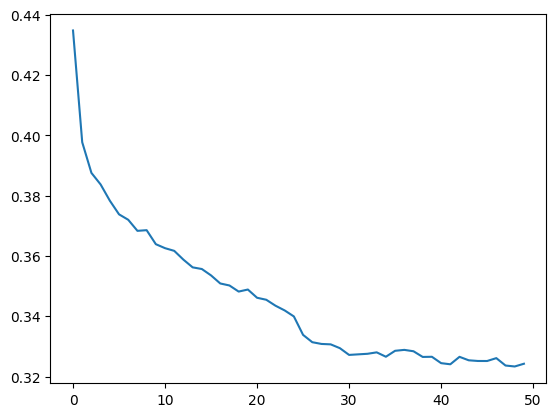

In [26]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1))

In [27]:
@torch.no_grad() # disable gradient tracking
def split_loss(split):
    x, y = {
        'train': (X_tr, Y_tr),
        'val': (X_val, Y_val),
        'dev': (X_dev, Y_dev),
    } [split]
    
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    
    
    print(f"{split}: {loss.item()}")

In [28]:
# put layers into eval mode
for l in model.layers:
    l.training = False

split_loss('train')
split_loss('val')
split_loss('dev')

train: 2.094944477081299
val: 2.4199159145355225
dev: 2.4150021076202393


# Generate Names

In [31]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialise with all ...
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
#         sample from distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
#         break when we reach '.'
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

المشطى.
شومي.
ححمي.
سما.
جلج.
عوف.
مجافر.
صحل.
مدرْبيَع.
مايه.
فرالدين.
فيفاء.
رتياء.
ريادة.
محماف.
كني.
سميح.
حسيد.
لوكا.
مسعودا.
